<a href="https://colab.research.google.com/github/M-Amrollahi/Personal-Notes/blob/master/ML-notes/circle_generator_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
import numpy as np
import torch
import torch.nn as nn
import random
import cv2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [182]:
def f_createRandomImage():
    x,y = 35,35
    max_r = 10
    rangex, rangey = (max_r,x-max_r), (max_r,y-max_r)
    colors = [((255, 255, 0),0),((120, 255,0),1),(( 255, 120,0),2),((0,255, 255),3),((0, 60, 60),4)]
    lst_res = []
    for color in colors:
        for i in range(1000):
            
            frame = np.full((x,y,3),0,dtype="uint8")

            locx = random.randint(*rangex)
            locy = random.randint(*rangey)
            r = random.randint(8,max_r)
            
            
            cv2.circle(frame,(locx,locy),r,color[0],-1)

            frame = frame / 255.0
            #cv2.rectangle(frame,(locx-r,locy-r),(locx+r,locy+r),(0,255,0),1)
            lst_res.append([frame.transpose(2,0,1), locx-r, locy-r, locx + r, locy + r, torch.nn.functional.one_hot(torch.tensor(color[1]), num_classes=5)])
            #cv2.waitKey(0)

    return lst_res

In [183]:
class cls_modelD(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6,kernel_size=(3,3)),
            nn.BatchNorm2d(6),
            nn.ReLU(),

            nn.Conv2d(in_channels=6, out_channels=12,kernel_size=(3,3)),
            nn.BatchNorm2d(12),
            nn.ReLU(),

            nn.MaxPool2d(2,2),

            nn.Flatten(1),

            nn.Linear(15*15*12,128),
            nn.ReLU(),

            nn.Linear(128,1),
            nn.Sigmoid()

        )

    def forward(self, x):
        return self.model.forward(x)

In [205]:
class cls_modelG(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.linModel = nn.Sequential( nn.Linear(5,39*39*3), nn.Tanh())

        self.model = nn.Sequential(
            
            # state size. (ngf*4) x 8 x 8
            #nn.ConvTranspose2d( 3, 3, 1,bias=False),
            #nn.BatchNorm2d(3),
            #nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            # state size. (ngf) x 32 x 32
            #nn.ConvTranspose2d( 3, 3, 1,bias=False),
            
            nn.Conv2d(3,6,3),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            #nn.Conv2d(3,3,1),
            
            #nn.ReLU(True),
            #nn.ReLU(),
            nn.Conv2d(6, 3, 3),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        x = self.linModel(x)
        x = x.reshape(x.shape[0], 3,39,39)
        return self.model.forward(x)

In [206]:
class cls_data(Dataset):
    def __init__(self,x) -> None:
        super().__init__()

        self.dataset = x
        

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        
        return torch.tensor(self.dataset.loc[index, "c"]).unsqueeze(dim=0), torch.tensor(self.dataset.loc[index, "image"]).permute((2,0,1))

In [207]:
lst_data = f_createRandomImage()

x = torch.tensor([i[0] for i in lst_data]).float()
x = x[torch.randperm(len(lst_data))]
trainLoader = DataLoader(x,batch_size=16)
x.dtype

torch.float32

In [208]:
modelD = cls_modelD()
criterion = nn.BCELoss()
optimD = torch.optim.Adam(modelD.parameters(), lr=4e-4)

modelG = cls_modelG()
optimG = torch.optim.Adam(modelG.parameters(), lr=4e-4)

In [209]:
real_label = 1.
fake_label = 0.

In [210]:
# Training Loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

modelD = modelD.to(device)
modelG = modelG.to(device)
print("Starting Training Loop...")
# For each epoch
for epoch in range(40):
    # For each batch in the dataloader
    sum_err = 0
    for i, data in enumerate(trainLoader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        optimD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        
        b_size = real_cpu.size(0)
        label = torch.full((b_size,1), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = modelD(real_cpu)
        # Calculate loss on all-real batch
        
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 5, device=device)
        # Generate fake image batch with G
        fake = modelG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = modelD(fake.detach())
        # Calculate D's loss on the all-fake batch
        
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = modelD(fake)
        # Calculate G's loss based on this output
        
        
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimG.step()

        sum_err += errG.detach().cpu().item()
    
    print(sum_err)

Starting Training Loop...
2115.7068564891815
2519.3113193511963
2659.827229499817
2722.4447236061096
2668.502640247345
2779.462656021118
2617.867045879364
2960.166101694107
2944.725734233856
2759.540783882141
2900.097285270691
3471.7077112197876
3621.793242454529
3593.7047123908997
3971.7262964248657
3187.1020543575287
3106.6672048568726
3263.2979917526245
3503.2304735183716
3608.1291937828064
3348.7269196510315
3374.3161911964417
3737.429561853409
3532.6790356636047
3264.909640312195
3267.7321882247925
3201.106985092163
3255.06134223938
3477.75492811203
3743.2375593185425
3903.9075083732605
3811.5580439567566
3759.5210604667664
3700.6286273002625
3584.564061164856
3749.2742590904236
3755.614770889282
4093.5515127182007
4261.48992061615
4168.217754840851


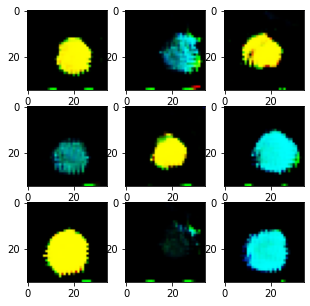

In [222]:
modelG.eval()
fixed_noise = torch.randn(9,5).to(device)

res = modelG(fixed_noise)
res = res*255
res = res.type(torch.uint8)

fig, ax = plt.subplots(3,3,figsize = (5,5))
ax = ax.ravel()
for i in range(len(res)):
    ax[i].imshow(res[i].permute(1,2,0).detach().cpu().numpy())

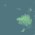

In [170]:
Image.fromarray(res[6].permute(1,2,0).detach().cpu().numpy())

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [129]:
a = torch.arange(20,30).reshape(5,-1)
a[torch.randperm(5)]


tensor([[26, 27],
        [28, 29],
        [22, 23],
        [20, 21],
        [24, 25]])